### Theoretisch beste:

Best RMSE parameters: {'n_factors': 1, 'n_epochs': 5, 'lr_all': 0.01, 'reg_all': 0.05, 'random_state': 1}

Best RMSE Score: 0.8355926869935398

### Sinnvoll beste:

SVD(n_factors=50, n_epochs=10, reg_all=0.07, lr_all=0.15, random_state=1)

RMSE Score: 0.8769050946401814

In [1]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
import random

# Function to recommend dive spots for a specific user
def recommend_dive_spots(user_id, svd_model, user_ratings_df, dive_sites_df, top_n=5):
    # Get all dive site IDs
    all_dive_sites = dive_sites_df["id"].unique()
    
    # Filter out dive sites the user has already rated
    rated_sites = user_ratings_df[user_ratings_df["user_id"] == user_id]["dive_site_id"].values
    unrated_sites = [site for site in all_dive_sites if site not in rated_sites]
    
    # Predict ratings for unrated dive sites
    predictions = []
    for dive_site_id in unrated_sites:
        pred = svd_model.predict(user_id, dive_site_id).est
        predictions.append((dive_site_id, pred))
    
    # Sort dive sites by predicted ratings in descending order
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Get the top N recommended dive sites
    top_dive_sites = predictions[:top_n]
    top_dive_site_ids = [site for site, _ in top_dive_sites]
    
    # Fetch details of the recommended dive sites
    recommended_sites = dive_sites_df[dive_sites_df["id"].isin(top_dive_site_ids)]
    return recommended_sites, top_dive_sites


def recommend_dive_regions(user_id, svd_model, user_ratings_df, dive_sites_df, top_n=5, max_sites_per_region=5):
    """
    Recommends top dive regions based on predicted ratings and groups them by region.
    Introduces randomness in sorting for ties and prioritizes lower indices for dive sites.
    """
    # Get all dive site IDs
    all_dive_sites = dive_sites_df[["id", "region"]].drop_duplicates()
    
    # Filter out dive sites the user has already rated
    rated_sites = user_ratings_df[user_ratings_df["user_id"] == user_id]["dive_site_id"].values
    unrated_sites = all_dive_sites[~all_dive_sites["id"].isin(rated_sites)]
    
    # Predict ratings for unrated dive sites
    predictions = []
    for _, row in unrated_sites.iterrows():
        dive_site_id = row["id"]
        region = row["region"]
        pred = svd_model.predict(user_id, dive_site_id).est
        predictions.append((dive_site_id, region, pred))
    
    # Convert predictions to DataFrame
    predictions_df = pd.DataFrame(predictions, columns=["dive_site_id", "region", "predicted_rating"])
    
    # Sort predictions by predicted ratings in descending order
    predictions_df = predictions_df.sort_values(by="predicted_rating", ascending=False)
    
    # Get the top N recommended dive sites
    top_dive_sites = predictions_df.head(100)
    
    # Group recommendations by region
    region_groups = top_dive_sites.groupby("region")
    
    # Calculate region scores (e.g., sum of site ratings in the region)
    region_scores = region_groups["predicted_rating"].mean().reset_index()
    region_scores.columns = ["region", "region_score"]
    
    # Introduce randomness in sorting for ties
    region_scores["random_tiebreaker"] = [random.random() for _ in range(len(region_scores))]
    top_regions = region_scores.sort_values(by=["region_score", "random_tiebreaker"], ascending=[False, True]).head(top_n)
    
    # Prepare region recommendations
    region_recommendations = []
    for region in top_regions["region"]:
        # Get top dive sites in the region, prioritize lower indices
        region_sites = top_dive_sites[top_dive_sites["region"] == region] \
                       .sort_values(by=["predicted_rating", "dive_site_id"], ascending=[False, True]) \
                       .head(max_sites_per_region)
        region_recommendations.append({
            "region": region,
            "top_sites": region_sites[["dive_site_id", "predicted_rating"]]
        })
    
    # Shuffle the region recommendations for further randomness
    region_recommendations
    
    return region_recommendations

In [2]:
# Load user ratings data and dive sites data
user_ratings_df = pd.read_csv("../user_ratings_data.csv")  # Replace with your data file
dive_sites_df = pd.read_csv('../dive_sites.csv')
features = pd.read_csv('../preferences.csv')

# Prepare data for surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(user_ratings_df[["user_id", "dive_site_id", "rating"]], reader)

trainset, testset = train_test_split(data, test_size=0.3, random_state=42)
# Train the SVD model
svd_model = SVD(n_factors=10, n_epochs=90, reg_all=0.07, lr_all=0.0005, random_state=1)
svd_model.fit(trainset)

# Input user ID and recommend dive spots
user_id = input("Enter User ID: ")
recommended_sites, top_dive_sites = recommend_dive_spots(user_id, svd_model, user_ratings_df, dive_sites_df, top_n=5)
print(f'Features for user {user_id}')
print(features[features['user_id']==user_id])
print(r' ')
# Display the recommendations
if recommended_sites.empty:
    print(f"No recommendations available for User {user_id}.")
else:
    print(f"\nRecommended Dive Spots for User {user_id}:")
    print(recommended_sites[["id", "title","name", "region", "cluster","animal_id"]])


Features for user 11
Empty DataFrame
Columns: [Unnamed: 0, user_id, preferred_regions, preferred_animals, preferred_types, preferred_clusters]
Index: []
 

Recommended Dive Spots for User 11:
        id            title                name          region  cluster  \
351    316        Cathedral            ['Reef']  Canary Islands        1   
501    474        Rons Reef            ['Reef']        Malaysia        1   
534    509         Ras Katy            ['Reef']           Egypt        1   
691    663       Eel Garden   ['Beach', 'Reef']           Egypt        1   
2701  2690  Terme del lacus  ['Archaeological']           Italy        2   

                                              animal_id  
351   [44, 203, 54, 24, 140, 12, 28, 65, 5, 35, 26, ...  
501           [4, 38, 20, 6, 10, 11, 12, 13, 2, 25, 27]  
534   [241, 25, 8, 28, 1, 20, 22, 23, 10, 21, 4, 12,...  
691   [25, 17, 5, 271, 272, 246, 203, 37, 38, 27, 80...  
2701                                       [54, 69, 30]  


In [5]:
# Nutzervektoren und Bias aus Supabase laden
user_vectors_data = supabase.table("user_vectors").select("*").execute().data
item_vectors_data = supabase.table("item_vectors").select("*").execute().data

# Daten umwandeln
user_factors = np.array([row["vector"] for row in user_vectors_data])
user_bias = np.array([row["bias"] for row in user_vectors_data])
item_factors = np.array([row["vector"] for row in item_vectors_data])
item_bias = np.array([row["bias"] for row in item_vectors_data])

# Modell rekonstruieren
from surprise import SVD

reconstructed_model = SVD(n_factors=10, n_epochs=90, reg_all=0.07, lr_all=0.0005, random_state=1)
reconstructed_model.pu = user_factors
reconstructed_model.qi = item_factors
reconstructed_model.bu = user_bias
reconstructed_model.bi = item_bias

recommended_sites, top_dive_sites = recommend_dive_spots('31837c9e-0832-4831-bb0a-d4ac37bd3cf5', svd_model, user_ratings_df, dive_sites_df, top_n=5)

print("Modell erfolgreich rekonstruiert!")


Modell erfolgreich rekonstruiert!


In [113]:
# Load user ratings data and dive sites data
user_ratings_df = pd.read_csv("../user_ratings_data.csv")  # Replace with your data file
dive_sites_df = pd.read_csv('../dive_sites.csv')
features = pd.read_csv('../preferences.csv')

# Prepare data for surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(user_ratings_df[["user_id", "dive_site_id", "rating"]], reader)
trainset, _ = train_test_split(data, test_size=0.3, random_state=42)

# Train the SVD model
svd_model = SVD(n_factors=10, n_epochs=90, reg_all=0.07, lr_all=0.0005, random_state=1)
svd_model.fit(trainset)

# Input user ID and recommend dive spots
user_id = 15
recommended_sites = recommend_dive_regions(user_id, svd_model, user_ratings_df, dive_sites_df, top_n=10)
print(f'Features for user {user_id}')
print(features[features['user_id']==user_id])
print(r' ')
# Display the recommendations

# Ergebnisse anzeigen
for rec in recommended_sites:
    print(f"\nRegion: {rec['region']}")
    print("Top Dive Sites:")
    print(rec["top_sites"])

Features for user 15
    Unnamed: 0  user_id                                  preferred_regions  \
14          14       15  ['Curacao', 'Federated States Of Micronesia', ...   

   preferred_animals    preferred_types preferred_clusters  
14         [409, 27]  ['Cave', 'Ocean']             [1, 5]  
 

Region: Guadeloupe
Top Dive Sites:
      dive_site_id  predicted_rating
2590          2627           3.84198

Region: East Timor
Top Dive Sites:
      dive_site_id  predicted_rating
3486          3553          3.811473

Region: Guam
Top Dive Sites:
      dive_site_id  predicted_rating
159            131          3.830521
2594          2863          3.780606

Region: Northern Mariana Islands
Top Dive Sites:
    dive_site_id  predicted_rating
22           353          3.792579

Region: Malaysia
Top Dive Sites:
      dive_site_id  predicted_rating
495            474          3.861289
1816          1839          3.777577
501            480          3.732033

Region: Spain
Top Dive Sites:
    

## Further Tests

Best RMSE parameters: {'n_factors': 1, 'n_epochs': 5, 'lr_all': 0.01, 'reg_all': 0.05, 'random_state': 1}
Best RMSE score: 0.8355926869935398


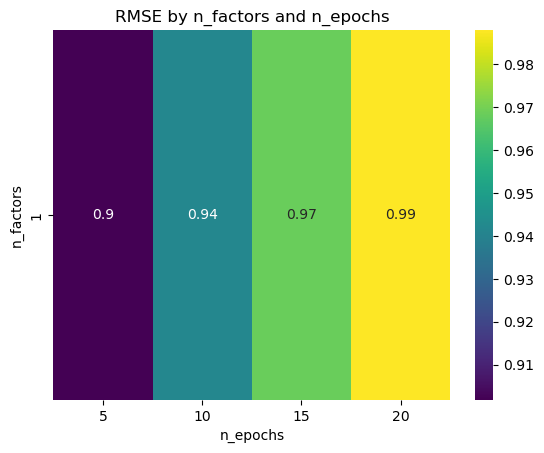

c:\Users\domin\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


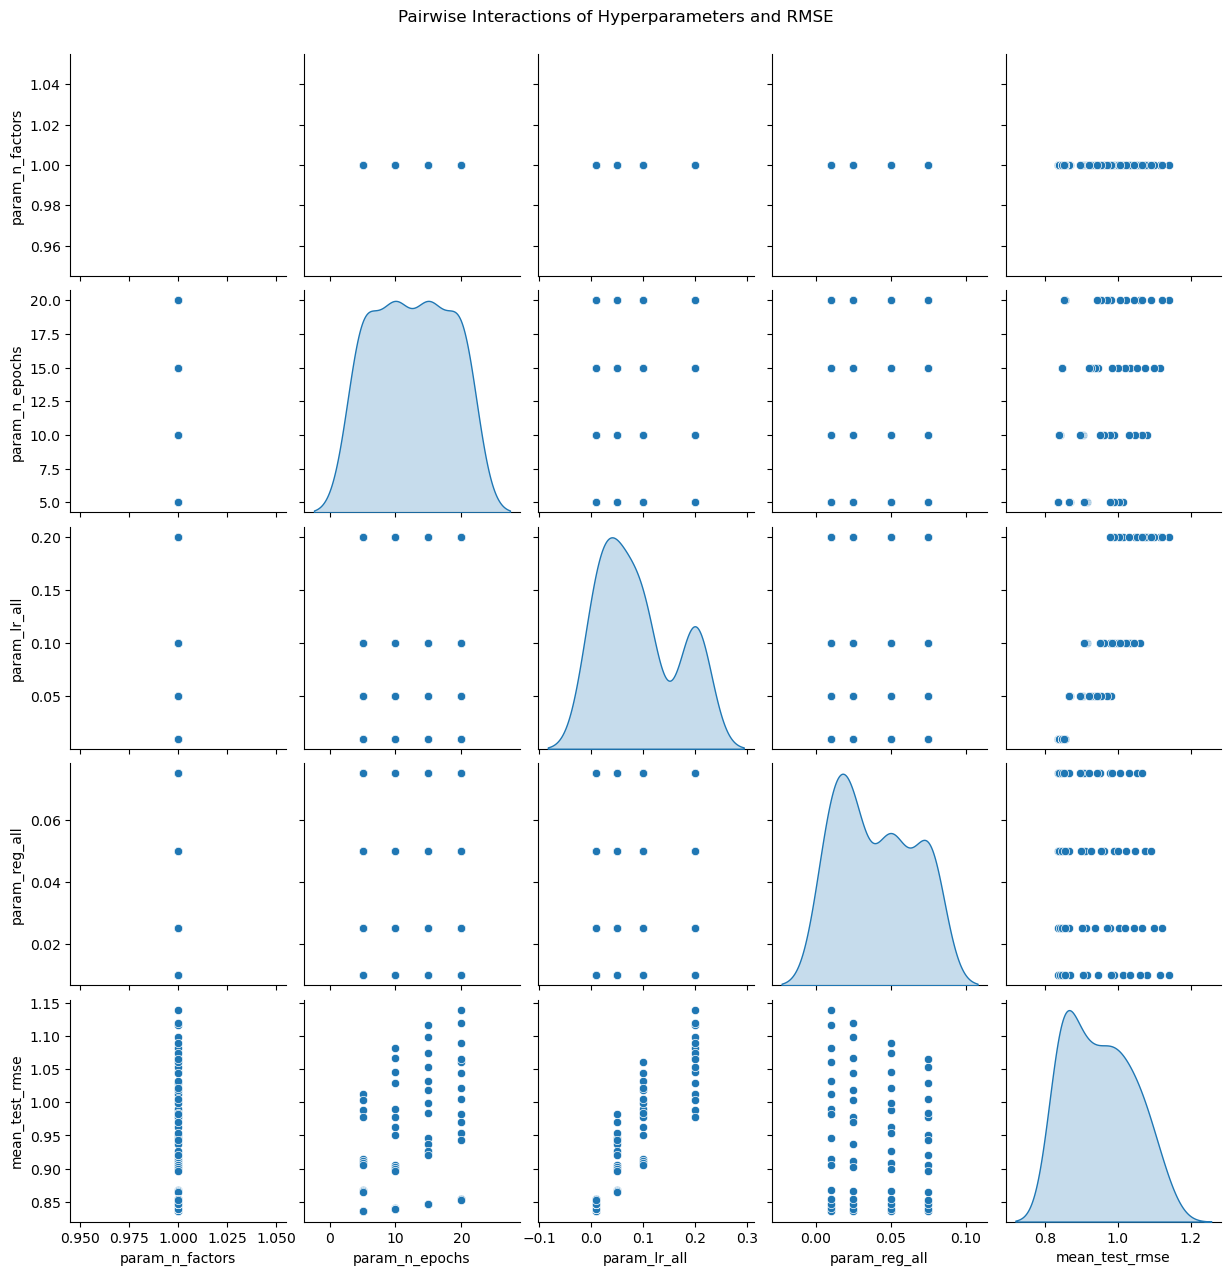

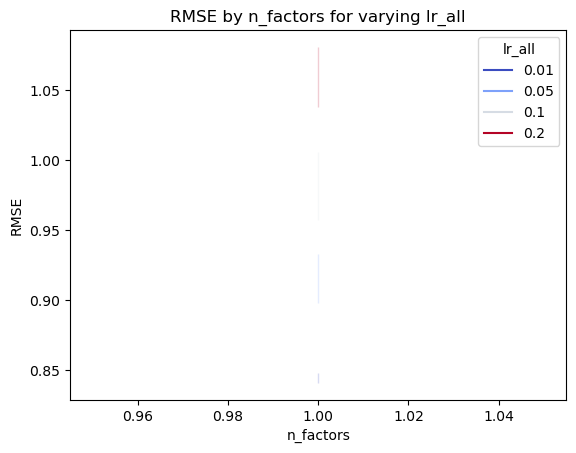

In [141]:
import pandas as pd
from surprise import SVD, Dataset, Reader
from surprise.model_selection import GridSearchCV, train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Load user ratings data
user_ratings_df = pd.read_csv("../user_ratings_data.csv")  # Replace with your actual file path

# Prepare data for surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(user_ratings_df[["user_id", "dive_site_id", "rating"]], reader)

# Define the parameter grid
param_grid = {
    'n_factors': range(1, 21, 20),  # Test values from 1 to 50 in steps of 10
    'n_epochs': range(5, 21, 5),   # Test values from 5 to 30 in steps of 5
    'lr_all': [0.01, 0.05, 0.1, 0.2],  # Test specific learning rates
    'reg_all': [0.01, 0.025, 0.05, 0.075],  # Test specific regularization values
    'random_state': [1]
}

# Perform grid search
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=2, n_jobs=-1)
gs.fit(data)

# Analyze best parameters and scores
best_params = gs.best_params["rmse"]
best_score = gs.best_score["rmse"]
print(f"Best RMSE parameters: {best_params}")
print(f"Best RMSE score: {best_score}")

# Convert results to DataFrame for visualization
results_df = pd.DataFrame(gs.cv_results)

# Visualizations
# 1. Heatmap of RMSE by n_factors and n_epochs
heatmap_data = results_df.pivot_table(index="param_n_factors", columns="param_n_epochs", values="mean_test_rmse")
sns.heatmap(heatmap_data, cmap="viridis", annot=True)
plt.title("RMSE by n_factors and n_epochs")
plt.xlabel("n_epochs")
plt.ylabel("n_factors")
plt.show()

# 2. Pairplot of parameter interactions and RMSE
sns.pairplot(results_df, vars=["param_n_factors", "param_n_epochs", "param_lr_all", "param_reg_all", "mean_test_rmse"], diag_kind="kde", kind="scatter")
plt.suptitle("Pairwise Interactions of Hyperparameters and RMSE", y=1.02)
plt.show()

# 3. Line Plot of RMSE by n_factors for each lr_all
sns.lineplot(data=results_df, x="param_n_factors", y="mean_test_rmse", hue="param_lr_all", palette="coolwarm")
plt.title("RMSE by n_factors for varying lr_all")
plt.xlabel("n_factors")
plt.ylabel("RMSE")
plt.legend(title="lr_all")
plt.show()

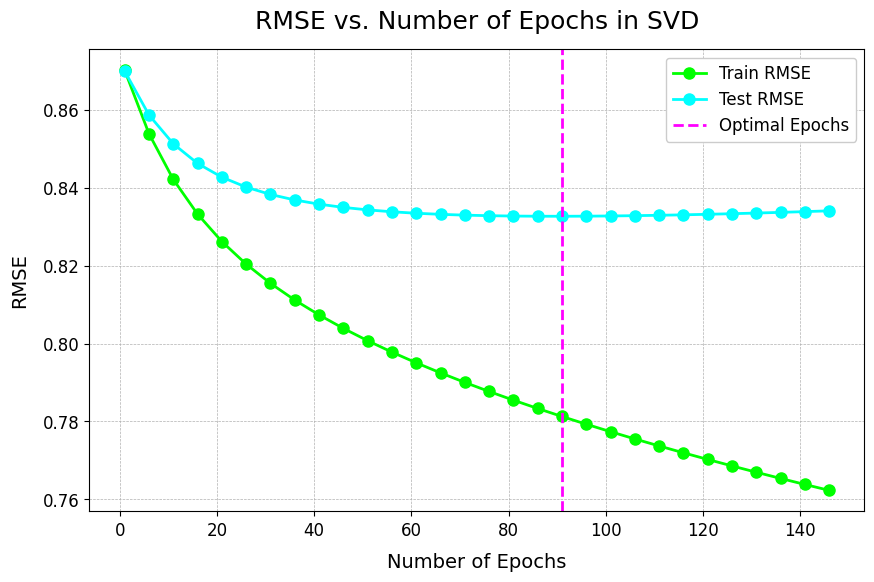

Optimal number of factors: 91
0.8326964490850836


In [2]:
import matplotlib.pyplot as plt
from surprise import SVD
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse,mae
import pandas as pd
from surprise import Reader, Dataset

user_ratings_df = pd.read_csv("../user_ratings_data.csv")  # Replace with your data file

# Prepare data for surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(user_ratings_df[["user_id", "dive_site_id", "rating"]], reader)

# Range of factors to test
n_factors_range = range(1, 150, 5)

# Store results
train_rmse = []
test_rmse = []

# Prepare train and test sets
trainset, testset = train_test_split(data, test_size=0.3, random_state=2)

# Loop through different numbers of factors
for n_factors in n_factors_range:
    # Build and train the SVD model
    svd = SVD(n_factors=10, n_epochs=n_factors, reg_all=0.07, lr_all=0.0005, random_state=1)
    svd.fit(trainset)
    
    # Evaluate on the train set
    train_predictions = svd.test(trainset.build_testset())
    train_rmse.append(rmse(train_predictions, verbose=False))
    
    # Evaluate on the test set
    test_predictions = svd.test(testset)
    test_rmse.append(rmse(test_predictions, verbose=False))

# Plot results
import matplotlib.pyplot as plt

# Customize plot with custom dark background (#06111C) and neon colors
plt.figure(figsize=(10, 6))  # Set figure background to #06111C
ax = plt.gca()  # Get current axes

# Define neon colors
train_color = '#00FF00'  # Neon green
test_color = '#00FFFF'   # Neon cyan
optimal_color = '#FF00FF'  # Neon magenta

# Plot with larger text and neon colors
plt.plot(n_factors_range, train_rmse, label='Train RMSE', marker='o', color=train_color, markersize=8, linewidth=2)
plt.plot(n_factors_range, test_rmse, label='Test RMSE', marker='o', color=test_color, markersize=8, linewidth=2)
plt.axvline(x=n_factors_range[test_rmse.index(min(test_rmse))], color=optimal_color, linestyle='--', label='Optimal Epochs', linewidth=2)

# Enhance titles and labels
plt.title('RMSE vs. Number of Epochs in SVD', fontsize=18, pad=15)
plt.xlabel('Number of Epochs', fontsize=14, labelpad=10)
plt.ylabel('RMSE', fontsize=14, labelpad=10)

# Customize tick parameters
ax.tick_params(axis='both', which='major', labelsize=12)  # Set tick labels to white
ax.tick_params(axis='both', which='minor', labelsize=10)

# Customize legend
plt.legend(fontsize=12, framealpha=1)  # Set legend text to white

# Add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display plot
plt.show()

# Print optimal number of factors
optimal_factors = n_factors_range[test_rmse.index(min(test_rmse))]
print(f"Optimal number of factors: {optimal_factors}")
print(min(test_rmse))



In [1]:
import matplotlib.pyplot as plt
from surprise import NMF, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse,mae
from tqdm import tqdm

data = Dataset.load_builtin('ml-100k')

# Range of factors to test
n_factors_range = range(1, 200, 10)  # Test factors from 2 to 100 in steps of 2

# Store results
train_rmse = []
test_rmse = []

# Prepare train and test sets
trainset, testset = train_test_split(data, test_size=0.3, random_state=2)

# Create a holdout set for validation
validation_set = trainset.build_testset()

# Loop through different numbers of factors with a progress bar
for n_factors in n_factors_range:
    # Build and train the SVD model
    svd = SVD(n_factors=1, n_epochs=n_factors, reg_all=0.07, lr_all=0.005, random_state=1)

    svd.fit(trainset)
    
    # Evaluate on the validation set
    train_predictions = svd.test(validation_set)
    train_rmse.append((rmse(train_predictions,verbose=False)))
    
    # Evaluate on the test set
    test_predictions = svd.test(testset)
    test_rmse.append((rmse(test_predictions,verbose=False)))

# Customize plot with custom dark background (#06111C) and neon colors
plt.figure(figsize=(10, 6), facecolor='#06111C')  # Set figure background to #06111C
ax = plt.gca()  # Get current axes
ax.set_facecolor('#06111C')  # Set axes background to #06111C

# Define neon colors
train_color = '#00FF00'  # Neon green
test_color = '#00FFFF'   # Neon cyan
optimal_color = '#FF00FF'  # Neon magenta

# Plot with larger text and neon colors
plt.plot(n_factors_range, train_rmse, label='Train RMSE', marker='o', color=train_color, markersize=8, linewidth=2)
plt.plot(n_factors_range, test_rmse, label='Test RMSE', marker='o', color=test_color, markersize=8, linewidth=2)
plt.axvline(x=n_factors_range[test_rmse.index(min(test_rmse))], color=optimal_color, linestyle='--', label='Optimal Epochs', linewidth=2)

# Enhance titles and labels
plt.title('RMSE vs. Number of Epochs in SVD', fontsize=18, color='white', pad=15)
plt.xlabel('Number of Epochs', fontsize=14, color='white', labelpad=10)
plt.ylabel('RMSE', fontsize=14, color='white', labelpad=10)

# Customize legend
plt.legend(fontsize=12, facecolor='#06111C', edgecolor='white', framealpha=1)

# Add grid
plt.grid(True, which='both', color='#444444', linestyle='--', linewidth=0.5)

# Display plot
plt.show()

# Print optimal number of factors
optimal_factors = n_factors_range[test_rmse.index(min(test_rmse))]
print(f"Optimal number of factors: {optimal_factors}")
print(min(test_rmse))


NameError: name 'SVD' is not defined